# Creating Metaformer model for detection of bowel injury in image

## Analysis of images with bowel_injury and extravasion_injury

In [1]:
# convenience directory variables
ROOT_DIR = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
TRAIN_DIR = f'{ROOT_DIR}/train_images'
SEG_DIR = f'{ROOT_DIR}/segmentations'

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import glob, os
import time
import PIL
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
# Table of images with visible injuries

In [4]:
image_level_labels = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv")
unique_injuries = image_level_labels['injury_name'].unique()
print("Unique injuries: ", unique_injuries)
image_level_labels.head(100)

Unique injuries:  ['Active_Extravasation' 'Bowel']


,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation
...,...,...,...,...
95,10004,51033,422,Active_Extravasation
96,10004,51033,423,Active_Extravasation
97,10004,51033,424,Active_Extravasation
98,10004,51033,425,Active_Extravasation


In [5]:
bowel_inj = image_level_labels[image_level_labels['injury_name'] == 'Bowel']
AcE_inj = image_level_labels[image_level_labels['injury_name'] == 'Active_Extravasation']
assert len(bowel_inj) + len(AcE_inj) == len(image_level_labels)

In [6]:
bowel_and_AcE = bowel_inj.merge(AcE_inj, on = ['patient_id', 'series_id', 'instance_number'])
data = image_level_labels.groupby(['patient_id','series_id','instance_number'])['injury_name'].apply(', '.join).reset_index()
assert len(data) + len(bowel_and_AcE) == len(image_level_labels)

In [7]:
data2 = data['injury_name'].str.get_dummies(sep=', ')
f_data = data.join(data2)
assert [len(row['injury_name'].split(', ' )) == row['Active_Extravasation']+ row['Bowel'] for i, row in f_data.iterrows()]

f_data.head()

,patient_id,series_id,instance_number,injury_name,Active_Extravasation,Bowel
0,33,55570,93,Bowel,0,1
1,33,55570,94,Bowel,0,1
2,33,55570,95,Bowel,0,1
3,33,55570,96,Bowel,0,1
4,33,55570,97,Bowel,0,1


In [8]:
dcm_path = []
for ind, row in f_data.iterrows():
    dcm_path.append(f"{TRAIN_DIR}/{row['patient_id']}/{row['series_id']}/{row['instance_number']}.dcm")

f_data.insert(loc=0,
          column='dcm_path',
          value=dcm_path)
f_data.head()

,dcm_path,patient_id,series_id,instance_number,injury_name,Active_Extravasation,Bowel
0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,93,Bowel,0,1
1,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,94,Bowel,0,1
2,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,95,Bowel,0,1
3,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,96,Bowel,0,1
4,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,97,Bowel,0,1


In [9]:
f_data.head()

,dcm_path,patient_id,series_id,instance_number,injury_name,Active_Extravasation,Bowel
0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,93,Bowel,0,1
1,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,94,Bowel,0,1
2,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,95,Bowel,0,1
3,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,96,Bowel,0,1
4,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,97,Bowel,0,1


 Now we need to add healthy sampels to the pot, but first we'll estimate their number.

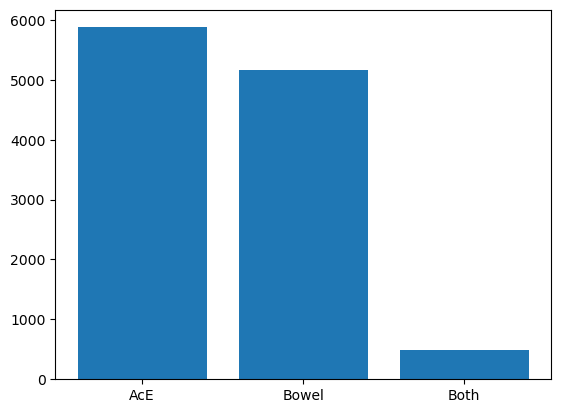

In [10]:
AcE_only = f_data.loc[(f_data['Active_Extravasation']==1) & (f_data['Bowel']==0), 'Active_Extravasation'].sum()
Bowel_only = f_data.loc[(f_data['Active_Extravasation']==0) & (f_data['Bowel']==1), 'Bowel'].sum()
AcE_Bowel = f_data.loc[(f_data['Active_Extravasation']==1) & (f_data['Bowel']==1), 'Active_Extravasation'].sum()

plt.bar([1,2,3], [AcE_only, Bowel_only, AcE_Bowel], align='center')
plt.xticks([1,2,3], ['AcE','Bowel','Both'])
plt.show()

In [11]:
# get all images from all patients
train_series_meta = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv")
all_samples = train_series_meta.drop(['aortic_hu', 'incomplete_organ'], axis=1)
train_series_meta.head(100)

patients_data = []
for index, row in tqdm(all_samples.iterrows(), total = len(all_samples)):
    path = f"{TRAIN_DIR}/{row['patient_id']}/{row['series_id']}"
    filenames = os.listdir(path)
    samples = [int(filename.split('.')[0]) for filename in filenames]
    patients_data.append(np.sort(samples))

all_samples['instances'] = patients_data

  0%|          | 0/4711 [00:00<?, ?it/s]

In [12]:
up_inst = f_data.merge(all_samples,on=['patient_id', 'series_id'], how='left')
up_inst.head()

,dcm_path,patient_id,series_id,instance_number,injury_name,Active_Extravasation,Bowel,instances
0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,93,Bowel,0,1,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3..."
1,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,94,Bowel,0,1,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3..."
2,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,95,Bowel,0,1,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3..."
3,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,96,Bowel,0,1,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3..."
4,/kaggle/input/rsna-2023-abdominal-trauma-detec...,33,55570,97,Bowel,0,1,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3..."


In [13]:
up_inst['instance_p'] = up_inst.apply(lambda x: np.where(x['instances'] == x['instance_number'])[0][0]/len(x['instances']), axis=1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


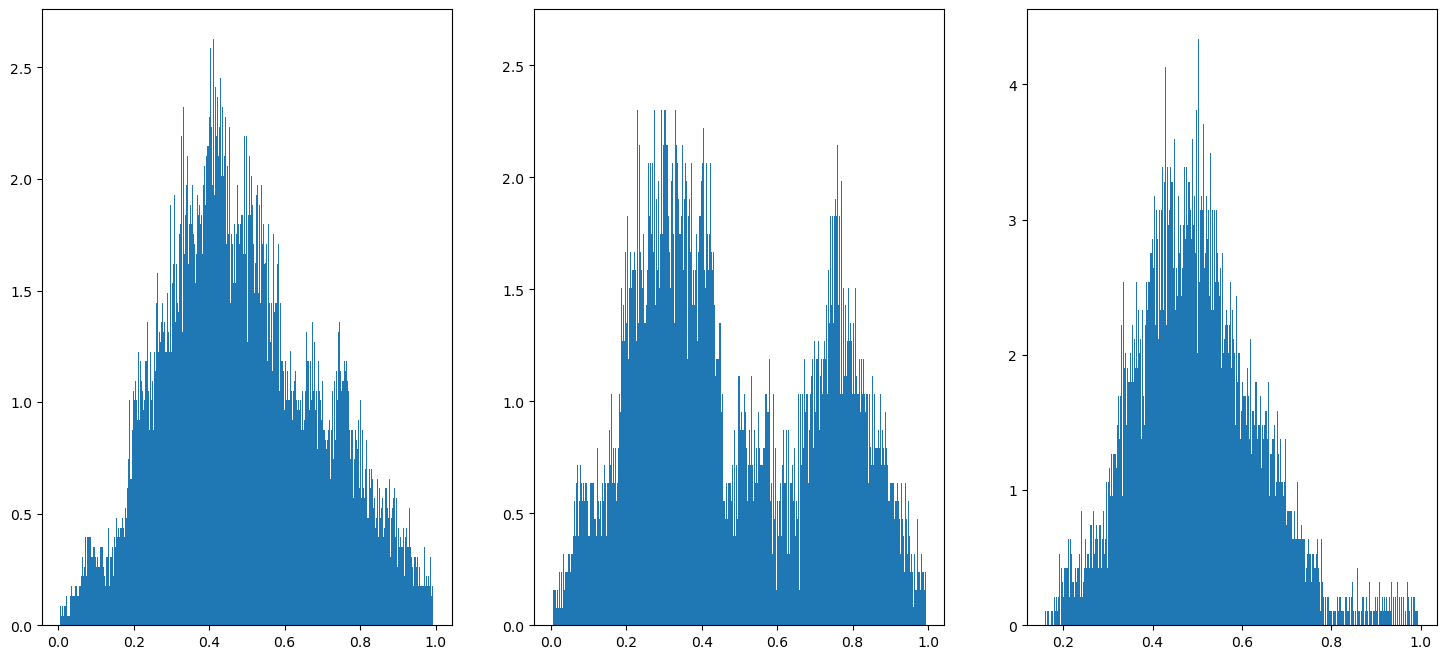

In [14]:
import scipy
from scipy import stats
fig, ax = plt.subplots(1,3, figsize=(18,8))

p_data_ace = up_inst[up_inst['Active_Extravasation']==1]['instance_p'].to_numpy()
p_data_bow = up_inst[up_inst['Bowel']==1]['instance_p'].to_numpy()
p_data_all = up_inst['instance_p'].to_numpy()

counts_all, bins_all = np.histogram(p_data_all, bins=500, density=True)
counts_ace, bins_ace = np.histogram(p_data_ace, bins=500, density=True)
counts_bow, bins_bow = np.histogram(p_data_bow, bins=500, density=True)

ax[0].hist(bins_all[:-1], bins_all, weights=counts_all)
ax[1].hist(bins_ace[:-1], bins_ace, weights=counts_ace)
ax[2].hist(bins_bow[:-1], bins_bow, weights=counts_bow)

plt.show()
#mu_all, sigma_all = scipy.stats.norm.fit(p_data)
#best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
#plt.plot(bins, best_fit_line)
#plt.title()
#plt.show()

In [15]:
from statistics import NormalDist
import random
random.seed(2137)
# We have 246 patients with either active extravasation or bowel injury
# now we'll get _ healthy patients and sample healthy images
def get_helthy(sick_pd, series_num, kernel_kde, s_num_range = (40,60))->pd.DataFrame:
    #samples_num = range(40,60)
    sample_dict = []
    sick_patients = sick_pd['series_id'].unique()
    healthy_patients = train_series_meta[~train_series_meta['series_id'].isin(sick_patients)].sample(series_num)
    healthy_patients = healthy_patients.merge(all_samples, on=['patient_id', 'series_id'])
    #sample images from healthy patients 50 from each
    for ind, row in healthy_patients.iterrows():
        instances = row['instances']
        instances_norm = [i/len(row['instances']) for i in range(1,len(instances)+1)]
        samples_num  = random.randrange(s_num_range[0], s_num_range[1])
        if samples_num > len(instances):
            samples_num = len(instances)

        probabilities = kernel_kde.pdf(instances_norm)
        probabilities /= np.sum(probabilities)


        probabilities += (1-sum(probabilities))/(len(instances_norm)-1)
        samples = np.random.choice(instances, size=samples_num, p=probabilities)
        for sample in samples:
            sample_dict.append({
                'dcm_path': f"{TRAIN_DIR}/{row['patient_id']}/{row['series_id']}/{sample}.dcm",
                'patient_id': row['patient_id'],
                'series_id': row['series_id'],
                'instance_number': sample,
                'injury_name': 'None',
                'Active_Extravasation': 0,
                'Bowel': 0, 
                'instances': row['instances']
            })

    healthy_samples = pd.DataFrame(sample_dict)

    return healthy_samples

6193


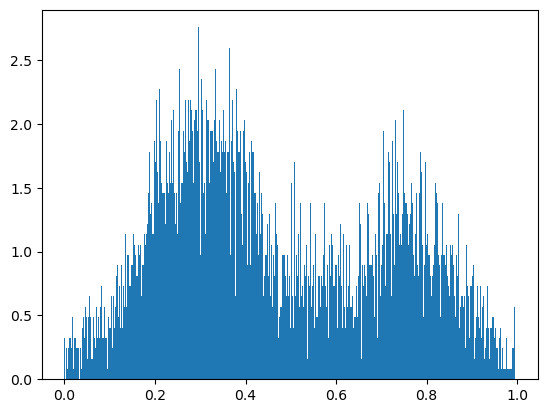

In [16]:
ace_kernel = stats.gaussian_kde(p_data_ace, bw_method='scott')
series_num = len(up_inst[up_inst['Active_Extravasation']==1]['series_id'].unique())
s_num_range = int(len(up_inst[up_inst['Active_Extravasation']==1])/series_num)
healthy_ace = get_helthy(f_data, series_num, ace_kernel, s_num_range = (s_num_range-10,s_num_range+10))
healthy_ace['instance_p'] = healthy_ace.apply(lambda x: np.where(x['instances'] == x['instance_number'])[0][0]/len(x['instances']), axis=1)
p_data = healthy_ace['instance_p'].to_numpy()
counts, bins = np.histogram(p_data, bins=500, density=True)
print(len(healthy_ace))
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

5576


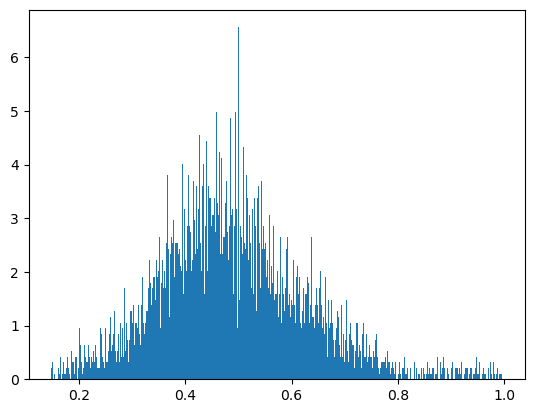

In [17]:
bowel_kernel = stats.gaussian_kde(p_data_bow, bw_method='scott')
series_num = len(up_inst[up_inst['Bowel']==1]['series_id'].unique())
s_num_range = int(len(up_inst[up_inst['Bowel']==1])/series_num)
healthy_bowel = get_helthy(f_data, series_num, bowel_kernel, s_num_range = (s_num_range-10,s_num_range+10))
healthy_bowel['instance_p'] = healthy_bowel.apply(lambda x: np.where(x['instances'] == x['instance_number'])[0][0]/len(x['instances']), axis=1)
p_data = healthy_bowel['instance_p'].to_numpy()
counts, bins = np.histogram(p_data, bins=500, density=True)
print(len(healthy_bowel))
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [18]:
full_data = pd.concat([f_data, healthy_ace.drop(['instances', 'instance_p'], axis=1), healthy_bowel.drop(['instances', 'instance_p'], axis=1)], axis=0)

In [19]:
print(full_data.head(10).to_string())

                                                                           dcm_path  patient_id  series_id  instance_number injury_name  Active_Extravasation  Bowel
0   /kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/33/55570/93.dcm          33      55570               93       Bowel                     0      1
1   /kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/33/55570/94.dcm          33      55570               94       Bowel                     0      1
2   /kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/33/55570/95.dcm          33      55570               95       Bowel                     0      1
3   /kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/33/55570/96.dcm          33      55570               96       Bowel                     0      1
4   /kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/33/55570/97.dcm          33      55570               97       Bowel                     0      1
5   /kaggl

# Prepare dataset

In [20]:
!pip install dicomsdl

import dicomsdl as dicoml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.3 MB/s eta 0:00:00


In [21]:
## load image with discosdl
def load_image(filepath:str, voi_lut = True):
    dataset = dicoml.open(filepath)
    img = dataset.pixelData()

    if voi_lut:
        # Load only the variables we need
        center = dataset["WindowCenter"]
        width = dataset["WindowWidth"]
        bits_stored = dataset["BitsStored"]
        voi_lut_function = dataset["VOILUTFunction"]
        
        # For sigmoid it's a list, otherwise a single value
        if isinstance(center, list):
            center = center[0]
        if isinstance(width, list):
            width = width[0]

        # Set y_min, max & range
        y_min = 0
        y_max = float(2**bits_stored - 1)
        y_range = y_max

        # Function with default LINEAR (so for Nan, it will use linear)
        if voi_lut_function == "SIGMOID":
            img = y_range / (1 + np.exp(-4 * (img - center) / width)) + y_min
        else:
            # Checks width for < 1 (in our case not necessary, always >= 750)
            center -= 0.5
            width -= 1

            below = img <= (center - width / 2)
            above = img > (center + width / 2)
            between = np.logical_and(~below, ~above)

            img[below] = y_min
            img[above] = y_max
            if between.any():
                img[between] = (
                    ((img[between] - center) / width + 0.5) * y_range + y_min
                )

    if dataset["PhotometricInterpretation"] == "MONOCHROME1":
        img = np.amax(img) - img

    if np.max(img) != 0:
        img = img / np.max(img)
    img=(img * 255).astype(np.uint8)

    return img

In [22]:
def prepare_sample(row, image_dirpath):
    img = load_image(row['dcm_path'])
    png_path = row['png_path']
    cv2.imwrite(png_path, img)

In [23]:
#create directory 
dataset_name = "RSNA_ICDataset"
dataset_dirpath = os.path.join(os.getcwd(), dataset_name)
os.makedirs(os.path.join(dataset_dirpath , "images"), exist_ok=True)
image_dirpath =   os.path.join(dataset_dirpath, 'images')

In [24]:
png_path = []
identifiers = []

for ind, row in full_data.iterrows():
    ide = f"{row['patient_id']}_{row['series_id']}_{row['instance_number']}"
    identifiers.append(ide)
    png_path.append(f'{image_dirpath}/{ide}.png')
    
im_meta = full_data
im_meta.insert(loc=1,
          column='png_path',
          value=png_path)

im_meta.insert(loc=2,
          column='identifier',
          value=identifiers)

In [25]:
im_meta = im_meta.drop_duplicates()

In [26]:
from joblib import Parallel, delayed
import cv2
import time

In [27]:
Parallel(n_jobs=4)(
    delayed(prepare_sample)(row, image_dirpath)
    for ind, row in im_meta.iterrows()
)
im_meta.to_pickle(f"{dataset_dirpath}/meta.pkl")
f_data.to_pickle(f"{dataset_dirpath}/sick_only.pkl")  
healthy_ace.to_pickle(f"{dataset_dirpath}/healthy_ace.pkl") 
healthy_bowel.to_pickle(f"{dataset_dirpath}/healthy_bowel.pkl") 

In [28]:
f_data.to_pickle(f"{dataset_dirpath}/sick_only.pkl")  
healthy_ace.to_pickle(f"{dataset_dirpath}/healthy_ace.pkl") 
healthy_bowel.to_pickle(f"{dataset_dirpath}/healthy_bowel.pkl") 

In [29]:
# TODO: finish for pretty injuries print
patient_scans = image_level_labels[image_level_labels['patient_id']==10004]
im_num = len(patient_scans)
continuity = 1
injuries = []
injuries_type = []

current_injury = []
current_inst_num = 0
current_type = None

for ind, row in patient_scans.iterrows():
    if ind==0:
        current_inst_num = row['instance_number']
        current_type = row['injury_name']
        current_injury.append(f"{TRAIN_DIR}/{row['patient_id']}/{row['series_id']}/{row['instance_number']}.dcm")
    else:
        if row['instance_number']-1 == current_inst_num and current_type == row['injury_name']:
            current_injury.append(f"{TRAIN_DIR}/{row['patient_id']}/{row['series_id']}/{row['instance_number']}.dcm")
            current_inst_num = row['instance_number']
        else:
            injuries.append(current_injury)
            injuries_type.append(current_type)
            
            current_injury = []
            current_injury.append(f"{TRAIN_DIR}/{row['patient_id']}/{row['series_id']}/{row['instance_number']}.dcm")
            current_inst_num = row['instance_number']
            current_type = row['injury_name']

In [30]:
patient_scans = image_level_labels[image_level_labels['series_id']==21057]
injury = []

for ind, row in patient_scans.iterrows():
    injury.append(f"{TRAIN_DIR}/{row['patient_id']}/{row['series_id']}/{row['instance_number']}.dcm")

In [31]:
image = []
for path in injury:
    img = load_image(path, voi_lut = True)
    image.append(img)

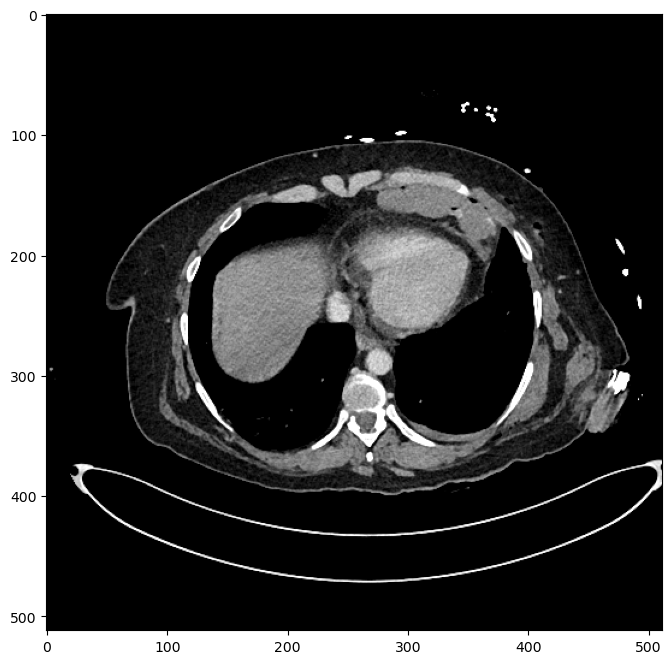

In [32]:
import matplotlib.animation as animation
from IPython.display import HTML

ima = np.stack(image, axis = 0)
fig, ax = plt.subplots(figsize=(16, 8))

im = ax.imshow(ima[0,:,:], cmap='gray', vmin=0, vmax = 255, animated=True)

amn = animation.FuncAnimation(fig, lambda i : im.set_array(ima[i,:,:]), frames=range(ima.shape[0]), repeat=True, repeat_delay=50000)

# Demonstrate the animation
HTML(amn.to_html5_video())